In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import IPython.display as display
import os

from classes import *
from tqdm import tqdm
from utils import *

from pyswip import Prolog
from typing import List, Tuple

# fix the seed for reproducibility (not fixing the seed for the whole program since we have imports!)
random.seed(666)
np.random.seed(666)

# minihack env creation with a .des file

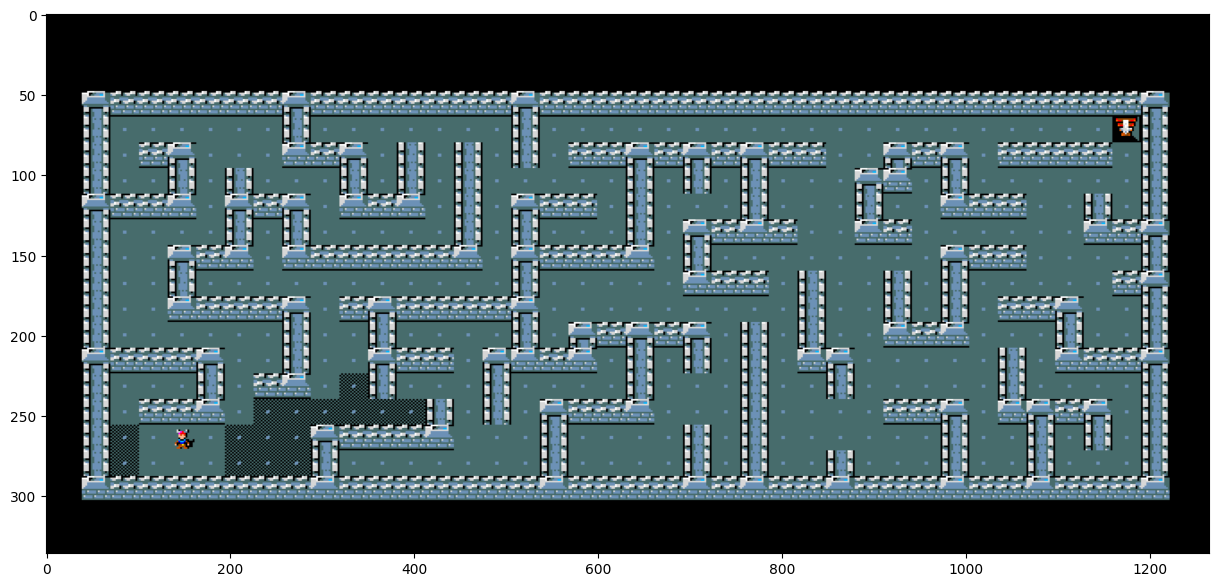

In [3]:
plt.rcParams["figure.figsize"] = [15, 7]
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file="maps/real_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
# env.render()
plt.imshow(state["pixel"], aspect="auto").set_data(state["pixel"][:, 300:950])  # type: ignore

(16, 23)


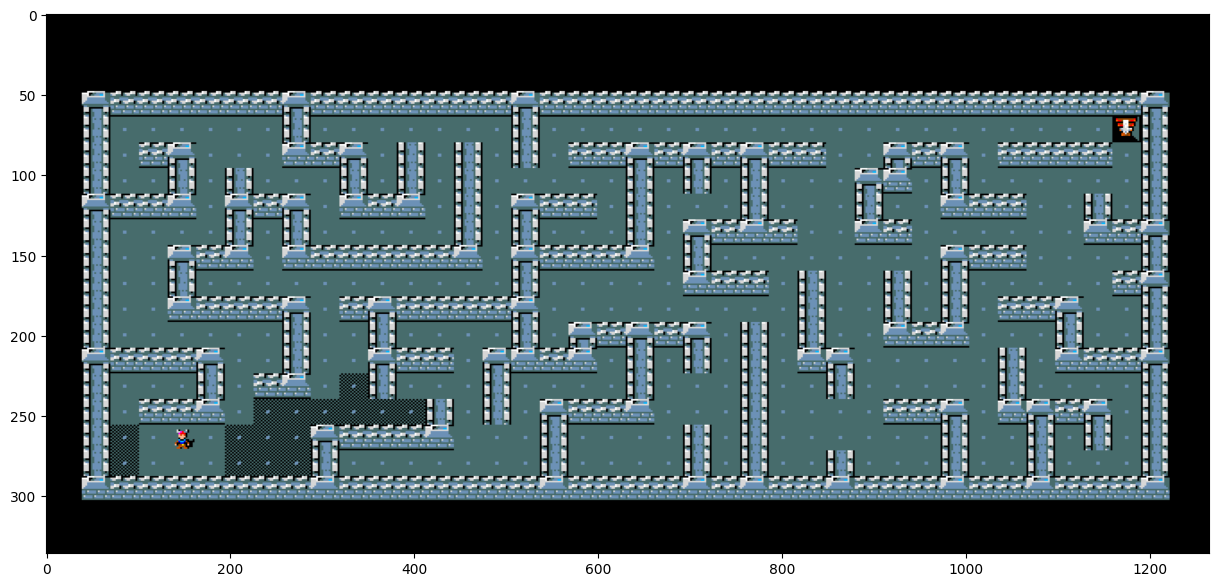

In [4]:


s,_,_,_ = env.step(0)

plt.imshow(s["pixel"], aspect="auto").set_data(s["pixel"][:, 300:950])  # type: ignore

print(get_player_location(s["chars"]))



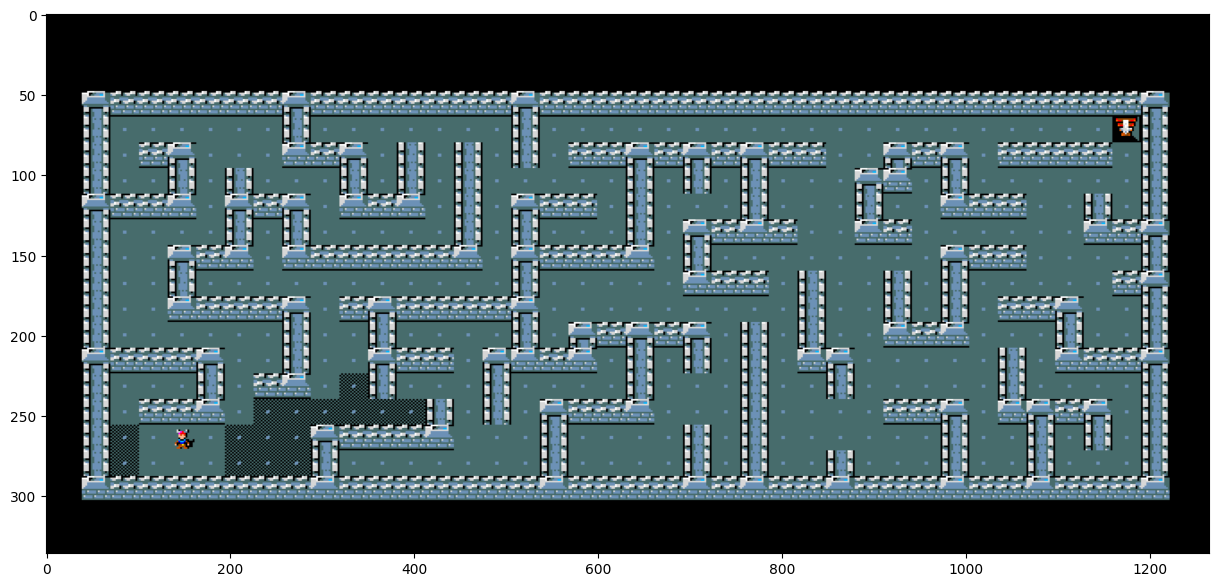

In [5]:

# env.render()
plt.imshow(state["pixel"], aspect="auto").set_data(state["pixel"][:, 300:950])  # type: ignore

In [6]:
state = env.reset()
game_map = state["chars"]  # type: ignore
game = state["pixel"]  # type: ignore
start = get_player_location(game_map)
target = get_target_location(game_map)
game_map = Map(game_map, start, target)

> start: (16, 23), target: (4, 56)
> map size: (21, 79)


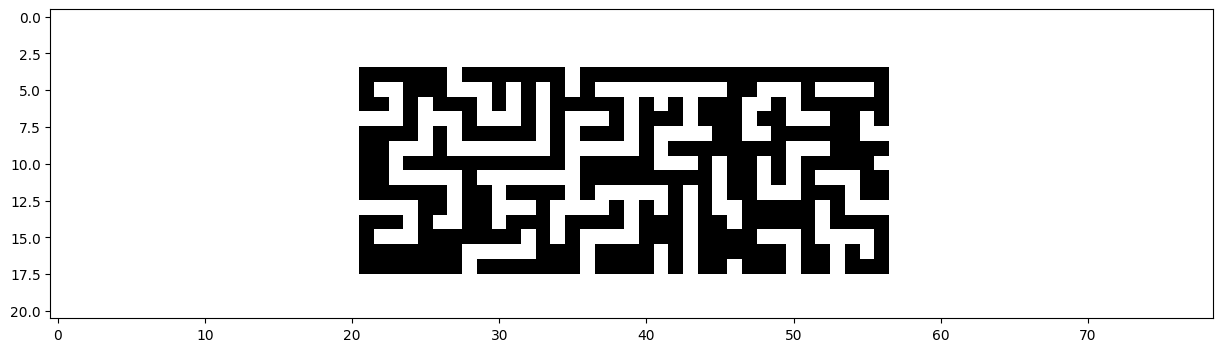

In [7]:
print(f"> start: {game_map.start}, target: {game_map.target}")
print(f"> map size: {game_map.layout.shape}")
# print the map_matrix with matplotlib where the walls are black and the floor is white
plt.imshow(game_map.map_matrix, cmap="gray") # type: ignore
plt.show()

In [8]:
PATH = "kb/kb.pl"
KB = Prolog()
KB.consult(PATH)

KB.retractall("maze(_)")
KB.retractall("start(_,_)")
KB.asserta(f"maze({game_map.map_matrix})")
KB.asserta(f"start({game_map.start[0]}, {game_map.start[1]})")

for i in KB.query("maze(X)"):
    print(f'{i["X"]}\n')  # type: ignore

# list(KB.query("maze(X)"))
# 1 corrisponde alle celle bianche, che non sono percorribili

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# NTH1

In Prolog, `nth1/3` is a built-in predicate that is used to access elements in a list by index. The `nth1/3` predicate has the following form:

```prolog
nth1(Index, List, Element)
```
Index: The index of the element you want to access.

List: The list from which you want to access the element.

Element: The variable that will be unified with the element at the specified index.


In [9]:
result = list(KB.query("maze(M), nth1(13, M, Row), nth1(25, Row, Cell)"))
if result:
    cell_value = result[0]["Cell"]  # type: ignore
    print(f"Cell value: {cell_value}")
else:
    print("Query result is empty.")

solution = list(KB.query(f"is_valid(14,25)"))
if solution:
    print("Position is valid.")
else:
    print("Position is not valid.")

l1 = list(KB.query("start(ROW,COL)"))
l2 = list(KB.query(f"is_valid(9,23)"))
l3 = list(KB.query(f"is_valid(9,23)"))
l4 = list(KB.query(f"is_valid_action(11,23,0)"))
l5 = list(KB.query(f"is_valid_action(10,23,0)"))
print(l1, l2, l3, l4, l5)

Cell value: 0
Position is not valid.
[{'ROW': 16, 'COL': 23}] [{}] [{}] [{}] [{}]


In [10]:
valid_actions = [0,1,2,3]

In [11]:
row = 16
col = 23

In [12]:
query_string = f"findall(Action, valid_cardinal_actions({row+1}, {col+1}, Action), Actions), intersection(Actions, {valid_actions}, ValidActions)"

results = list(KB.query(query_string))

In [13]:
print(result)

[{'M': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
valid_actions_result = results[0]['ValidActions'] # type: ignore

print(valid_actions_result)

[1, 2, 3]


In [15]:
get_valid_actions(game_map.layout,  (row, col))

[1, 2, 3]

In [16]:
print(is_wall(game_map.layout[row, col+1]))

False


In [16]:
# for i in range(len(game_map.map_matrix)): # type: ignore
#     for j in range(len(game_map.map_matrix[0])): # type: ignore
#         result = list(KB.query(f"maze(M), nth1({i+1}, M, Row), nth1({j+1}, Row, Cell)"))
#         if result:
#             cell_value = result[0]["Cell"]  # type: ignore
#             if game_map.map_matrix[i][j] != cell_value:
#                 #print(f'{i+1},{j+1} is valid')
#             #else: 
#                 #print(f'{i+1},{j+1} is not valid, ERROR!!!!!')
#                 break
#         else:
#             print("Query result is empty.")

In [30]:
random.seed(42)

actions = random_nactions(10)
print(actions)

path = path_from_actions(game_map= game_map.layout, start = game_map.start, actions = actions)
print(path)

path_kb = path_from_actions_kb(game_map= game_map.layout, start = game_map.start, actions = actions, KB = KB)
print(path_kb)

[2, 0, 1, 0, 2, 2, 3, 0, 1, 0]
[(17, 23), (16, 23), (16, 24), (16, 24), (17, 24), (17, 24), (17, 23), (16, 23), (16, 24), (16, 24)]
[(17, 23), (16, 23), (16, 24), (16, 24), (17, 24), (17, 24), (17, 23), (16, 23), (16, 24), (16, 24)]


In [18]:
path1 = random_nsteps(game_map= game_map.layout, start = game_map.start, target=game_map.target, steps = 10)
path1

[(16, 22),
 (16, 23),
 (17, 23),
 (16, 23),
 (16, 24),
 (16, 25),
 (17, 25),
 (16, 25),
 (16, 24),
 (17, 24)]

In [19]:
actions1 = actions_from_path(start = game_map.start, path = path1)
actions1

[3, 1, 2, 0, 1, 1, 2, 0, 3, 2]

In [20]:
path2 = path_from_actions(game_map= game_map.layout, start = game_map.start, actions = actions1)
path2

[(16, 22),
 (16, 23),
 (17, 23),
 (16, 23),
 (16, 24),
 (16, 25),
 (17, 25),
 (16, 25),
 (16, 24),
 (17, 24)]

In [34]:
# generating a full valid random path to feed at the first generation
starting_path = random_nsteps(game_map= game_map.layout, start = game_map.start, target=game_map.target, steps = 300)
starting_actions = actions_from_path(start = game_map.start, path = starting_path)
print(len(starting_actions))
print(starting_actions)

300
[1, 1, 0, 1, 3, 2, 0, 2, 1, 1, 2, 0, 3, 2, 1, 3, 0, 2, 1, 0, 0, 2, 3, 3, 1, 0, 1, 1, 3, 1, 3, 1, 0, 0, 1, 0, 3, 1, 3, 2, 1, 3, 1, 3, 1, 2, 2, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 0, 0, 2, 3, 1, 3, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 3, 2, 2, 2, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 0, 2, 0, 2, 0, 2, 3, 3, 1, 1, 3, 3, 3, 2, 0, 2, 0, 1, 1, 1, 3, 3, 3, 2, 2, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 0, 3, 2, 0, 0, 0, 2, 2, 2, 0, 1, 1, 0, 2, 3, 2, 1, 0, 2, 3, 3, 1, 1, 3, 3, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 3, 3, 1, 2, 0, 1, 3, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 2, 3, 1, 0, 0, 0, 1, 1, 3, 1, 1, 0, 2, 3, 1, 3, 3, 1, 1, 0, 2, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 0, 2, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 0, 2, 3, 3, 3, 1, 3, 1, 3, 1, 3, 2, 0, 2, 0, 1, 1, 3, 1, 1, 0, 2, 0, 2, 3, 1, 0, 2, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1]


# We have to decide if we want to generate a random path or random actions

random path $\Rightarrow$ a path of exactly n steps

random actions $\Rightarrow$ many action will be not valid $\Rightarrow$ the path will be shorter OR, as is implemented now, with many repetition of the same position.

# NOTE:
minihack wont crash if we input a not valid action starting from a valid action. It will simply not execute the action (as if we are playing), hence we are updating the path position with the same position.

# Note
we can both initialize a n random action or a random n steps path generated in the cells above.

In [35]:
# create first generation
MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 16

best_individuals = []

print("> Creating initial population...")
individuals = [
    Individual(starting_actions, 1, game_map) for _ in range(MAX_INDIVIDUALS)
]
"""individuals = [
    Individual(random_nactions(300), 1, game_map) for _ in range(MAX_INDIVIDUALS)
]"""
individuals.sort(key=lambda x: x.fitness, reverse=True)
print("> Evolving...")

with tqdm(total=MAX_GENERATIONS, colour='#9244c9', ncols=150) as pbar:
    for generation in range(MAX_GENERATIONS):
        best_fitness = individuals[0].fitness
        best_individuals.append(individuals[0])
        if generation % 25 == -1:
            print(
                format_loop.format(
                    generation,
                    best_fitness,
                    individuals[0].wrong_actions,
                    individuals[0].loops,
                    individuals[0].dead_ends,
                    individuals[0].distance,
                )
            )

        # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
        # also roulette wheel selection.
        p1, p2 = individuals[0], individuals[1]
        errors = p1.error_vector + p2.error_vector

        offspring = [
            softmax_mutate(
                crossover(p1.actions, p2.actions), 
                errors, 
                generation=generation, 
                mutation_rate=0.8,
                max_generations=MAX_GENERATIONS
            )
            for _ in range(MAX_INDIVIDUALS)
        ]

        individuals[2:] = [
            Individual(offspring[i], generation + 1, game_map)
            for i in range(MAX_INDIVIDUALS - 2)
        ]
        individuals.sort(key=lambda x: x.fitness, reverse=True)

        if individuals[0].fitness == 0:
            print(
                f"> best individual in generation {generation}: {individuals[0].fitness}, wrong actions: {individuals[0].wrong_actions}"
            )
            break

        pbar.set_postfix(
            best_fitness=best_fitness, 
            distance=individuals[0].distance, 
            dead_ends=individuals[0].dead_ends, 
            loops=individuals[0].loops, 
            wrong_actions=individuals[0].wrong_actions,
            refresh=False
        )
        
        pbar.update(1)

best_fitness = individuals[0].fitness
best_individuals.append(individuals[0])

> Creating initial population...
> Evolving...


100%|██████████████████████████████████████| 1000/1000 [01:43<00:00,  9.67it/s, best_fitness=96, dead_ends=0, distance=0, loops=57, wrong_actions=118]


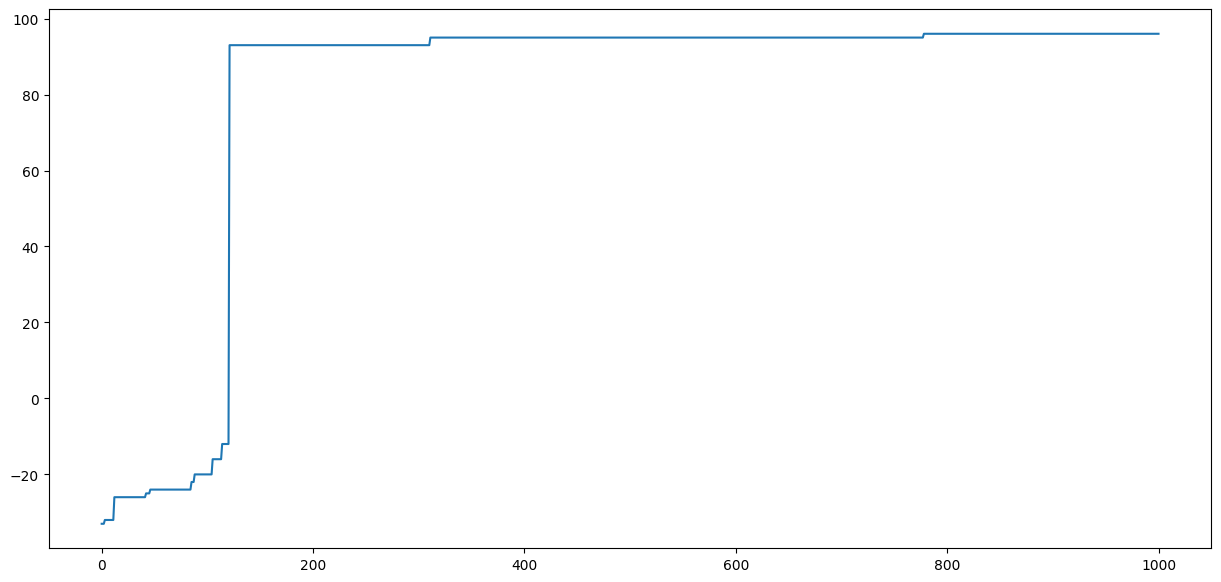

In [36]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

YOU WON! <3


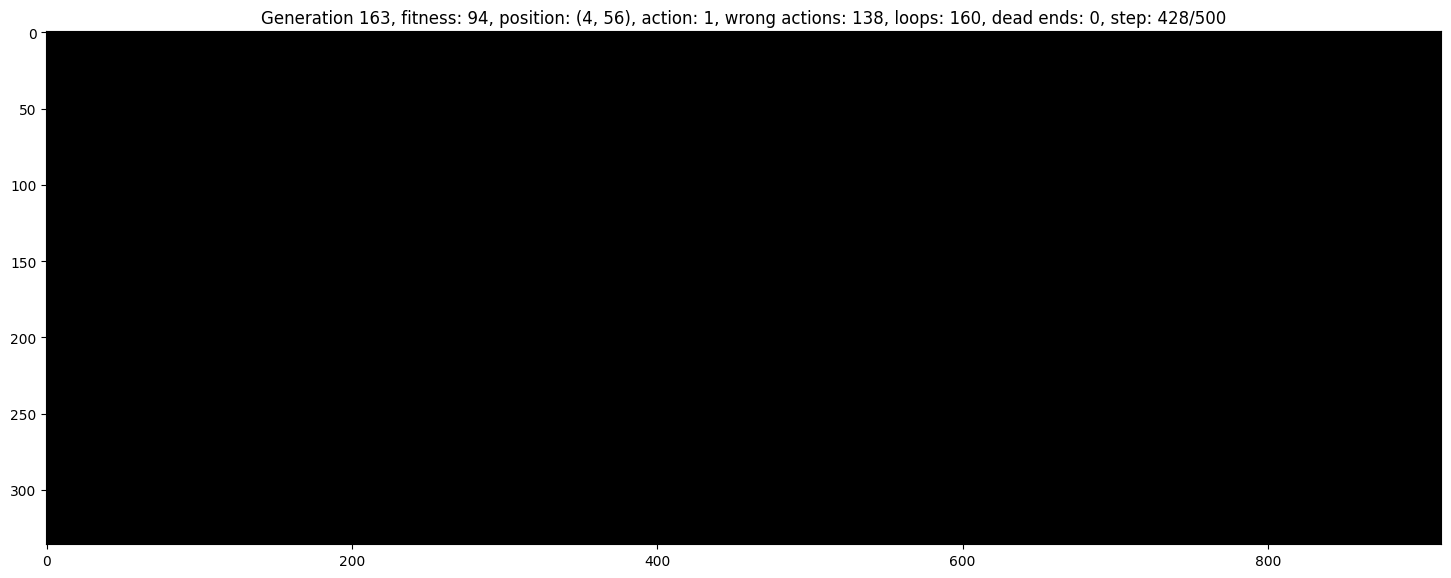

In [23]:
env.reset()
plt.rcParams["figure.figsize"] = [18, 7]

image = plt.imshow(game[:, 350:1500])
# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
# start = best_paths[0]
# path = best_paths[-1]
actions = []
actions = individuals[0].actions
wrong = 0

for i, action in enumerate(actions):
    try:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(
            format_title.format(
                individuals[0].generation,
                individuals[0].fitness,
                individuals[0].path[i],
                action,
                wrong,
                individuals[0].loops,
                individuals[0].dead_ends,
                i + 1,
                len(actions),
            )
        )
        image.set_data(s["pixel"][:, 300:1200])
        # time.sleep(0.1)
        if individuals[0].path[i] == game_map.target:
            print("YOU WON! <3")
            break
        if individuals[0].path[i] == individuals[0].path[i - 1]:
            wrong += 1
    except RuntimeError:
        print("YOU WON! <3")